In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Reading Dataset

In [2]:
# Kaggle dataset link: https://www.kaggle.com/datasets/deepu1109/star-dataset
df = pd.read_csv('../../datasets/stars.csv')

df.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,0
1,3042,0.000500,0.1542,16.60,Red,M,0
2,2600,0.000300,0.1020,18.70,Red,M,0
3,2800,0.000200,0.1600,16.65,Red,M,0
4,1939,0.000138,0.1030,20.06,Red,M,0


In [3]:
# Convert categorical data to numerical data
df["Color"] = df["Color"].astype('category').cat.codes
df["Spectral_Class"] = df["Spectral_Class"].astype('category').cat.codes

df.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,8,5,0
1,3042,0.000500,0.1542,16.60,8,5,0
2,2600,0.000300,0.1020,18.70,8,5,0
3,2800,0.000200,0.1600,16.65,8,5,0
4,1939,0.000138,0.1030,20.06,8,5,0


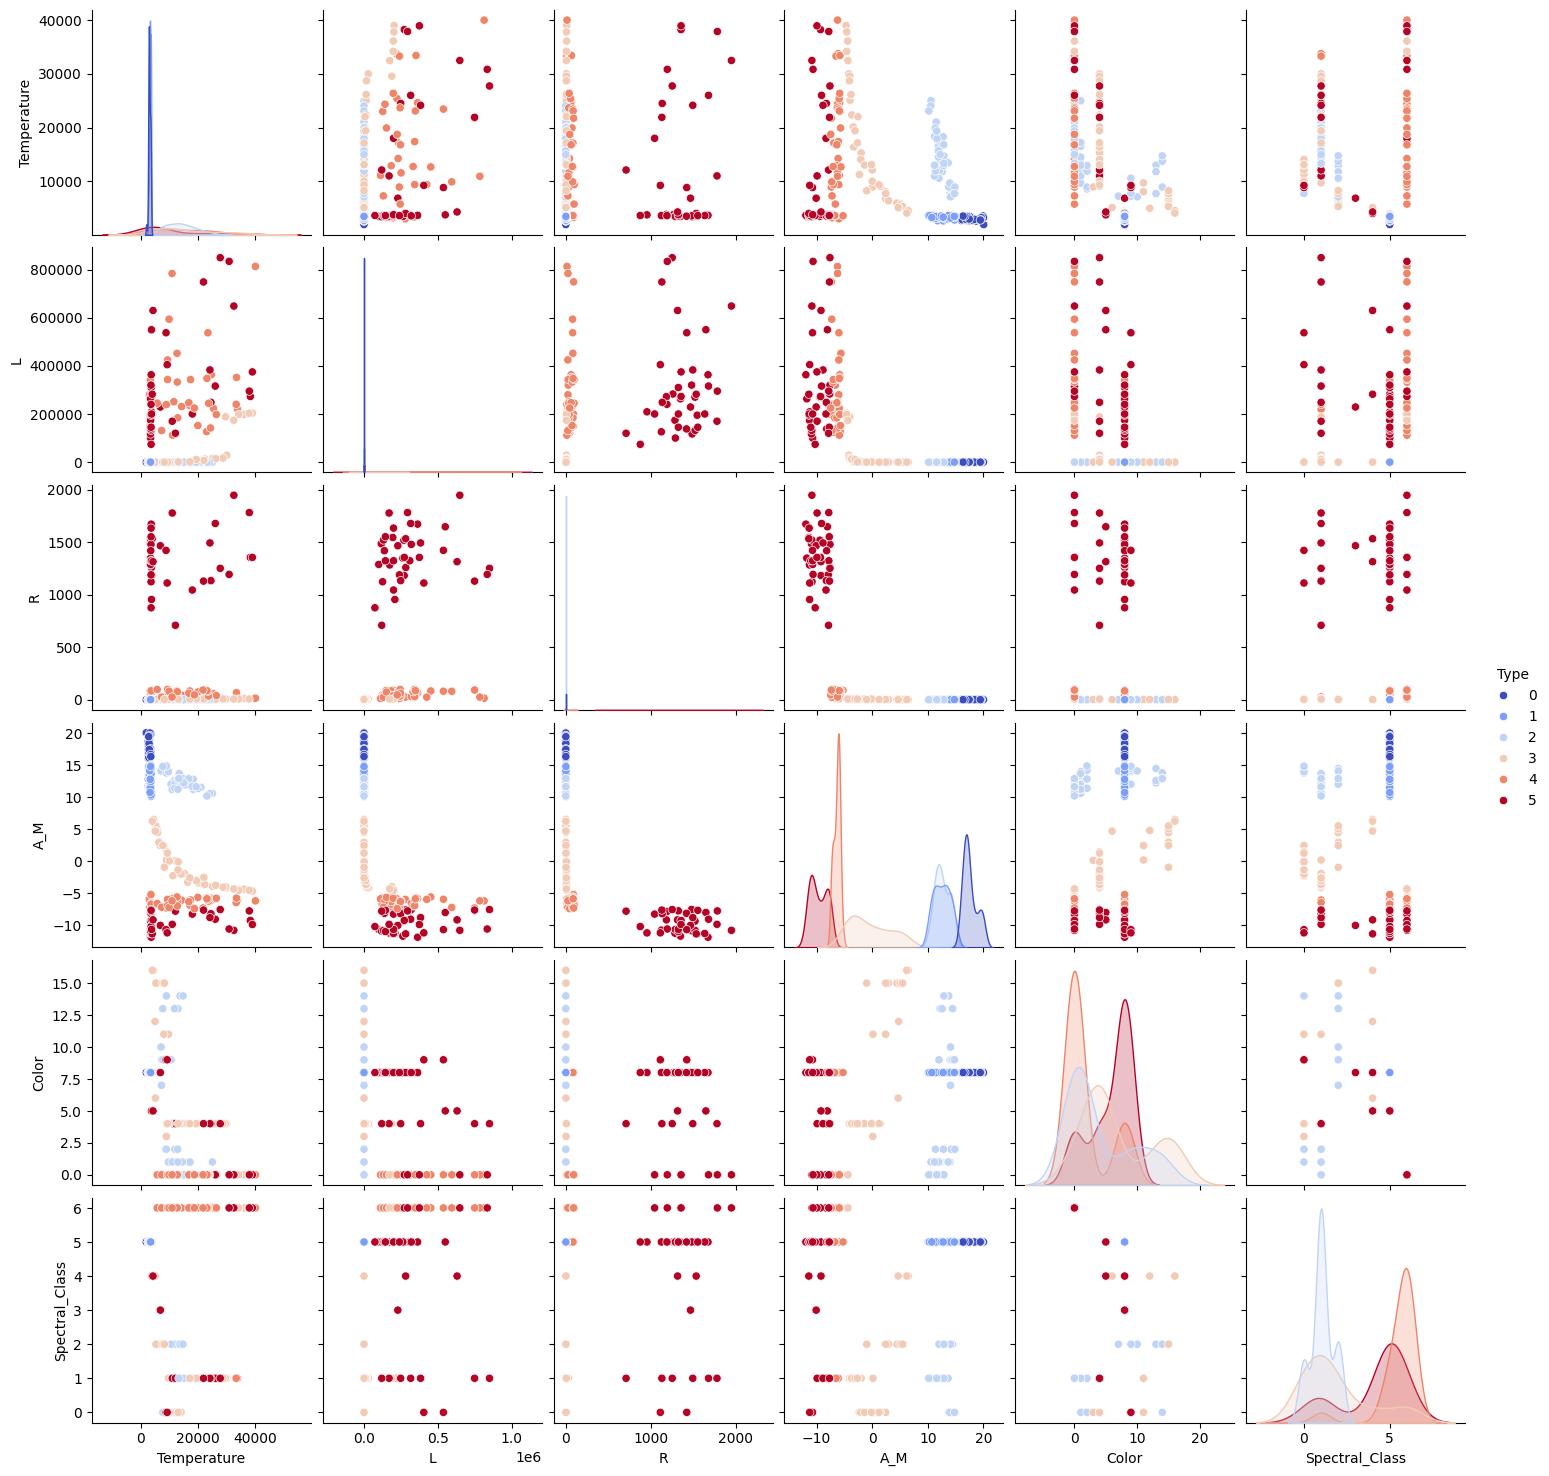

In [4]:
sns.pairplot(df, hue='Type', palette='coolwarm')

In [5]:
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Selecting Features & Converting to Tensor

In [6]:
# selecting Absolute Magnitude, Temperature, and Radius as features
X = StandardScaler().fit_transform(
        df[['A_M', 'Temperature', 'R']]
    )

y = df['Type'].to_numpy()

# 80% training, 20% testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# converting to tensor with proper data type
x_train = t.tensor(x_train, dtype=t.float32)
x_test = t.tensor(x_test, dtype=t.float32)
y_train = t.tensor(y_train, dtype=t.int64) # categorical data musst be integer (long integer)
y_test = t.tensor(y_test, dtype=t.int64)

X.shape, y.shape

((240, 3), (240,))

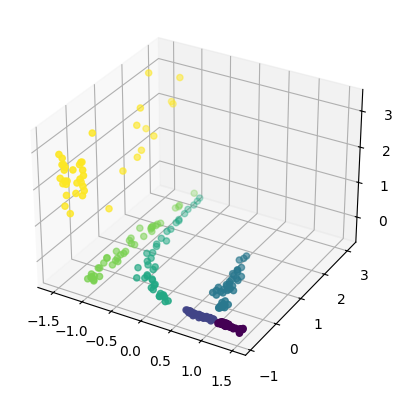

In [7]:
# 3d plot X with hue of y
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)
plt.show()

# Training 

In [8]:
def train(model, x_train, y_train, x_test, y_test, loss_function, optimizer, epochs=100):
    losses = []

    for epoch in range(epochs):
        predictions = model(x_train)

        loss = loss_function(predictions, y_train)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        # evaluate loss on test set
        with t.no_grad():
            predictions = model(x_test)
            loss = loss_function(predictions, y_test)
            losses.append(loss.item())

    return losses

# Model, Loss function, and Optimizer

In [9]:
# Create a torch.nn Module (nn.Sequential contain submodules in order)
input_size = X.shape[1]
output_size = len(df['Type'].unique())
model = nn.Sequential(
    nn.Linear(input_size, output_size), 

    # nn.Linear(input_size, 10),
    # nn.Linear(10, output_size),

    # nn.Linear(input_size, 10),
    # nn.ReLU(),
    # nn.Linear(10, 10),
    # nn.ReLU(),
    # nn.Linear(10, output_size),
)

# use nn.functional.cross_entropy directly
# nn.CrossEntropyLoss() would also work but unnecessary
loss_function = F.cross_entropy 

# If a module contains any learnable parameters, it will register them as parameters.
optimizer = optim.Adam(model.parameters())

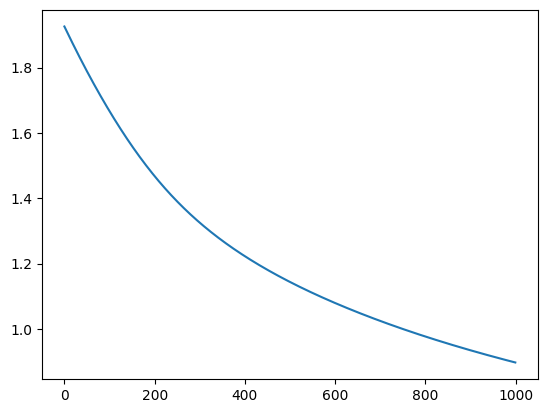

In [10]:
losses = train(
    model, 
    x_train, y_train, 
    x_test, y_test, 
    loss_function, 
    optimizer, 
    epochs=1000
)
plt.plot(losses)

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [12]:
predictions = model(x_test)
accuracy_score(y_test, t.argmax(predictions, dim=1))

0.6041666666666666

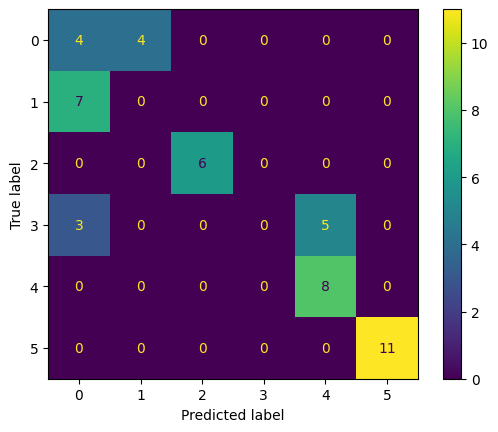

In [13]:
ConfusionMatrixDisplay(confusion_matrix(y_test, t.argmax(predictions, dim=1))).plot()

# Custom Module

In [14]:
# custom module can be created by extending nn.Module
class CustomModule(nn.Module):
    def __init__(self):
        super().__init__()
        # --- any nn.Module attributes with parameters will be registered as parameters in the overall module
        self.layer1 = nn.Linear(3, 6)
        self.layer2 = nn.Linear(6, 6) 

        # --- custom parameters (nn.ParameterList or nn.ParameterDict)
        # self.params = nn.ParameterDict({ 
        #     'weight': nn.Parameter(t.randn(3, 6)),
        #     'bias': nn.Parameter(t.randn(6)),
        #     ...
        # })

        # --- or override nn.Module's parameters directly
        # self.parameters = [t.randn(3, 6), t.randn(6)]

    '''
        m = CustomModule()
        m.forward(x)
    or  m(x)
    '''
    def forward(self, x):
        y = self.layer1(x)
        y = F.relu(y)
        y = self.layer2(y)
        return y

# Reusable Model Class

In [15]:
# A complete model class with n layers and fit method.
class Model(nn.Module):
    def __init__(self, shapes, activations, loss_function, optimizer, optim_params={}):
        super().__init__()
        self.shapes = shapes
        self.activations = activations
        self.loss_function = loss_function

        self.layers = nn.ModuleList([
            nn.Linear(shapes[i], shapes[i + 1]) for i in range(len(shapes) - 1)
        ])

        self.optimizer = optimizer(self.parameters(), **optim_params)
    
    def forward(self, x):
        y = x
        for i in range(len(self.layers)):
            y = self.layers[i].forward(y)
            if self.activations[i] is not None:
                y = self.activations[i](y)
        return y

    def loss(self, x, y):
        return self.loss_function(self.forward(x), y)
    
    def fit(self, x_train, y_train, x_test, y_test, epochs=100):
        losses = []

        for epoch in range(epochs):
            predictions = self.forward(x_train)

            loss = self.loss_function(predictions, y_train)
            loss.backward()

            self.optimizer.step()
            self.optimizer.zero_grad()

            # evaluate loss on test set
            with t.no_grad():
                predictions = self.forward(x_test)
                loss = self.loss_function(predictions, y_test)
                losses.append(loss.item())

            if epoch % 100 == 0:
                print(f'Epoch {epoch}: {loss.item()}')

        return losses

Epoch 0: 1.8775830268859863
Epoch 100: 0.29834890365600586
Epoch 200: 0.11981210112571716
Epoch 300: 0.0647110864520073
Epoch 400: 0.040538765490055084


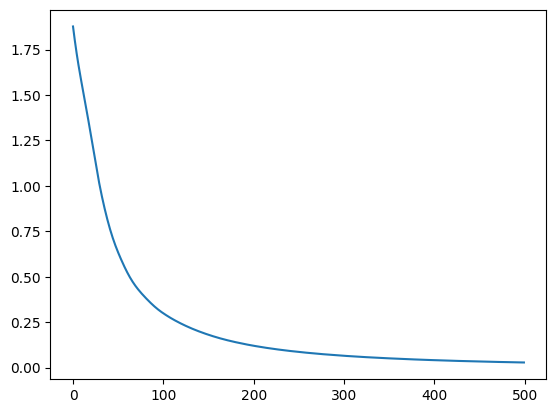

In [16]:
m = Model(
    [X.shape[1], 10, 6], 
    [F.relu, None],
    F.cross_entropy,
    optim.Adam,
    optim_params={'lr': 0.01}
)

losses = m.fit(x_train, y_train, x_test, y_test, epochs=500)
plt.plot(losses)

In [19]:
# save model's parameters 
t.save(m.state_dict(), 'star_model.pth')
t.onnx.export(m, x_train, 'star_model.onnx')
t.jit.save(m, 'star_model.pt')

AttributeError: 'Model' object has no attribute 'save'